In [24]:

"""

from scipy.signal import butter, filtfilt, detrend

EOG_COLS = ["EOG_left_h", "EOG_right_h", "EOG_left_v", "EOG_right_v"]

def butter_filter(x, fs, low=None, high=None, order=3):
    nyq = fs / 2.0
    if (low is not None and high is not None):
        btype = "bandpass"
        Wn = [low/nyq, high/nyq]
    elif (high is not None):
        btype = "lowpass"
        Wn = high/nyq
    elif (low is not None):
        btype = "highpass"
        Wn = low/nyq
    else:
        return x
    b, a = butter(order, Wn, btype=btype)
    return filtfilt(b, a, x)

def detrend_and_butter_inplace(df, fs, low=0.05, high=20.0, order=3):
    for col in EOG_COLS:
        if col not in df.columns:
            raise KeyError(f"В файле нет колонки '{col}'. Есть: {list(df.columns)}")

        x = pd.to_numeric(df[col], errors="coerce").to_numpy(dtype=float)

        x = detrend(x, type="linear")
        x = x - np.nanmedian(x)

        if np.any(~np.isfinite(x)):
            med = np.nanmedian(x)
            x = np.where(np.isfinite(x), x, med)

        df[col] = butter_filter(x, fs=fs, low=low, high=high, order=order)
    return df

fs = 500
df_et = [detrend_and_butter_inplace(df, fs=fs) for df in df_et]
df_pd = [detrend_and_butter_inplace(df, fs=fs) for df in df_pd]

print("Preprocessing done. Example shapes:", df_et[0].shape if df_et else None, df_pd[0].shape if df_pd else None)



"""

'\n\nfrom scipy.signal import butter, filtfilt, detrend\n\nEOG_COLS = ["EOG_left_h", "EOG_right_h", "EOG_left_v", "EOG_right_v"]\n\ndef butter_filter(x, fs, low=None, high=None, order=3):\n    nyq = fs / 2.0\n    if (low is not None and high is not None):\n        btype = "bandpass"\n        Wn = [low/nyq, high/nyq]\n    elif (high is not None):\n        btype = "lowpass"\n        Wn = high/nyq\n    elif (low is not None):\n        btype = "highpass"\n        Wn = low/nyq\n    else:\n        return x\n    b, a = butter(order, Wn, btype=btype)\n    return filtfilt(b, a, x)\n\ndef detrend_and_butter_inplace(df, fs, low=0.05, high=20.0, order=3):\n    for col in EOG_COLS:\n        if col not in df.columns:\n            raise KeyError(f"В файле нет колонки \'{col}\'. Есть: {list(df.columns)}")\n\n        x = pd.to_numeric(df[col], errors="coerce").to_numpy(dtype=float)\n\n        x = detrend(x, type="linear")\n        x = x - np.nanmedian(x)\n\n        if np.any(~np.isfinite(x)):\n        

In [25]:
import re
import numpy as np
import pandas as pd
import os, glob, re
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import scipy.signal as signal
from scipy.io import savemat
import zipfile
from google.colab import files

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score

import pywt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
base = "/content/drive/MyDrive/CAL_CSV"
et_dir = os.path.join(base, "ET")
pd_dir = os.path.join(base, "PD")

def load_numeric(dir_path):
    files = glob.glob(os.path.join(dir_path, "*.csv"))
    pairs = []
    for p in files:
        name = os.path.splitext(os.path.basename(p))[0]
        m = re.search(r"\d+", name)
        if m:
            pairs.append((int(m.group()), p))
    pairs.sort(key=lambda x: x[0])

    idx = [i for i, _ in pairs]
    dfs = [pd.read_csv(p) for _, p in pairs]

    if idx and idx != list(range(min(idx), max(idx) + 1)):
        missing = sorted(set(range(min(idx), max(idx) + 1)) - set(idx))
        print("Missing indices:", missing)

    return dfs, idx

df_et, et_idx = load_numeric(et_dir)
df_pd, pd_idx = load_numeric(pd_dir)

print("ET:", len(df_et), "files", "min/max:", (min(et_idx), max(et_idx)) if et_idx else None)
print("PD:", len(df_pd), "files", "min/max:", (min(pd_idx), max(pd_idx)) if pd_idx else None)

if df_et:
    print("ET columns:", list(df_et[0].columns))
if df_pd:
    print("PD columns:", list(df_pd[0].columns))


Missing indices: [2, 4]
Missing indices: [4, 7, 8, 9, 10, 14, 15]
ET: 8 files min/max: (0, 9)
PD: 10 files min/max: (0, 16)
ET columns: ['EOG_left_h', 'EOG_right_h', 'EOG_left_v', 'EOG_right_v', 'head_horizontal', 'head_frontal', 'head_sagittal']
PD columns: ['EOG_left_h', 'EOG_right_h', 'EOG_left_v', 'EOG_right_v', 'head_horizontal', 'head_frontal', 'head_sagittal']


In [27]:
df_et[0]

,EOG_left_h,EOG_right_h,EOG_left_v,EOG_right_v,head_horizontal,head_frontal,head_sagittal
0,27.620691,3.536544,-41.981998,43.679216,0.000000,0.000000,0.000000
1,27.620691,3.536544,-41.981998,43.679216,-0.000323,0.000638,0.001129
2,27.620691,3.536544,-41.981998,43.679216,-0.000645,0.001275,0.002256
3,27.620691,3.536544,-41.981998,43.679216,-0.000967,0.001909,0.003381
4,27.620691,3.536544,-41.981998,43.679216,-0.001289,0.002542,0.004502
...,...,...,...,...,...,...,...
12994,-49.180167,22.487833,19.062803,-49.299531,-0.000883,0.003866,0.007286
12995,-49.180167,22.487833,19.062803,-49.299531,-0.000715,0.003143,0.005884
12996,-49.180167,22.487833,19.062803,-49.299531,-0.000545,0.002420,0.004481
12997,-49.180167,22.487833,19.062803,-49.299531,-0.000375,0.001698,0.003077


In [28]:
import plotly.graph_objects as go

def interactive_eog_single_plot_fixed(df, column="EOG_left_v", title="Single Channel", height=900):

    x_coords = [1000, 2500, 4000, 5500, 7000, 8500, 10000, 11500]

    #delta = 1000
    #x_coords = [coord+delta for coord in x_coords]

    if column not in df.columns:
        raise KeyError(f"Колонка '{column}' не найдена. Есть: {list(df.columns)}")

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[column],
            mode="lines",
            name=column,
            line=dict(width=1),
            hovertemplate="x=%{x}<br>y=%{y}<extra></extra>"
        )
    )

    for x in x_coords:
        fig.add_vline(
            x=x,
            line_dash="dash",
            line_color="red",
            line_width=1,
            opacity=0.7
        )

    fig.update_layout(
        height=height,
        width=1400,
        title_text=f"{title} - {column}",
        showlegend=True,
        dragmode="zoom",
        hovermode="closest",
        margin=dict(l=60, r=40, t=80, b=60)
    )

    fig.update_xaxes(title_text="Индекс записи", showspikes=True, spikemode="across", spikesnap="cursor", spikedash="dot")
    fig.update_yaxes(title_text="Значение", showspikes=True, spikemode="across", spikesnap="cursor", spikedash="dot")

    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="left",
                buttons=list([
                    dict(args=[{"dragmode": "zoom"}], label="Zoom", method="relayout"),
                    dict(args=[{"dragmode": "pan"}], label="Pan", method="relayout"),
                    dict(args=[{"dragmode": "select"}], label="Select Area", method="relayout"),
                ]),
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.08,
                yanchor="top"
            )
        ]
    )

    fig.show()
    return fig

In [29]:
import os, re
import numpy as np
import pandas as pd

SIDE = "l"  # "l" или "r"

PD_REMAP = {0:0,1:1,2:2,3:3,4:None,5:4,6:5,7:None,8:None,9:None,10:None,11:6,12:7,13:8,14:None,15:None,16:9}
ET_REMAP = {0:0,1:1,2:None,3:2,4:None,5:3,6:4,7:5,8:6,9:7}

manual_base = "/content"
manual_ET = pd.read_csv(os.path.join(manual_base, f"{SIDE}_manual_ET.csv"))
manual_PD = pd.read_csv(os.path.join(manual_base, f"{SIDE}_manual_PD.csv"))

col = "EOG_left_v"

# Селект импульсов:
# если что, удалил первый и последний так как особенности сигнала
ROW_IDX = [1, 2, 3, 4, 5, 6]

def extract_old_patient_ids(manual_df: pd.DataFrame, group: str):
    ids = set()
    pat = re.compile(rf"^{group}_(\d+)_(a|b)$")
    for c in manual_df.columns:
        m = pat.match(c)
        if m:
            ids.add(int(m.group(1)))
    return sorted(ids)

def build_amp_table_from_manual(manual_df: pd.DataFrame,
                                group: str,
                                remap: dict,
                                dfs_group: list,
                                col: str,
                                row_idx: list[int]):
    use_rows = [r for r in row_idx if 0 <= r < len(manual_df)]
    impulse_nums = [r + 1 for r in use_rows]

    old_ids = extract_old_patient_ids(manual_df, group)

    new_ids = []
    old_to_new = {}
    for old in old_ids:
        new = remap.get(old, None)
        old_to_new[old] = new
        if new is not None and 0 <= new < len(dfs_group):
            new_ids.append(new)
    new_ids = sorted(set(new_ids))

    out = pd.DataFrame({"Unnamed: 0": impulse_nums})
    for new in new_ids:
        out[f"patient_{new}"] = np.nan

    for old in old_ids:
        new = old_to_new[old]
        if new is None or not (0 <= new < len(dfs_group)):
            continue

        df_sig = dfs_group[new]
        if col not in df_sig.columns:
            raise KeyError(f"В сигнале new_id={new} нет колонки '{col}'. Есть: {list(df_sig.columns)}")

        x = pd.to_numeric(df_sig[col], errors="coerce").to_numpy(dtype=float)

        col_a = f"{group}_{old}_a"
        col_b = f"{group}_{old}_b"
        if col_a not in manual_df.columns or col_b not in manual_df.columns:
            continue

        for rr_i, rr in enumerate(use_rows):
            a = manual_df.iloc[rr][col_a]
            b = manual_df.iloc[rr][col_b]
            if pd.isna(a) or pd.isna(b):
                continue

            a = int(a); b = int(b)
            if len(x) == 0:
                continue
            a = max(0, min(len(x) - 1, a))
            b = max(0, min(len(x) - 1, b))

            out.loc[rr_i, f"patient_{new}"] = float(x[a] - x[b])

    return out

amp_et = build_amp_table_from_manual(manual_ET, "ET", ET_REMAP, df_et, col, ROW_IDX)
amp_pd = build_amp_table_from_manual(manual_PD, "PD", PD_REMAP, df_pd, col, ROW_IDX)

print("ET")
display(amp_et)
print("PD")
display(amp_pd)


ET


,Unnamed: 0,patient_0,patient_1,patient_2,patient_3,patient_4,patient_5,patient_6,patient_7
0,2,15.077508,22.421849,21.494831,39.121017,26.430097,17.659757,27.019343,25.029737
1,3,13.493603,25.951229,23.130135,38.529594,34.117379,19.343763,NaN,28.240141
2,4,14.296261,27.664584,12.133205,36.266414,23.635182,16.979281,29.321734,NaN
3,5,16.657709,25.070934,13.949684,23.525516,24.789182,16.401805,NaN,27.610408
4,6,16.109338,31.992396,8.951582,31.166564,29.757842,NaN,24.326977,25.029525
5,7,14.972956,NaN,13.490478,32.314498,26.238054,18.620801,NaN,25.590088


PD


,Unnamed: 0,patient_0,patient_1,patient_2,patient_3,patient_4,patient_5,patient_6,patient_7,patient_8,patient_9
0,2,20.320241,35.531089,22.492720,NaN,33.445894,NaN,21.310942,27.782665,33.840693,23.564108
1,3,25.248802,34.434616,19.737110,NaN,27.227359,NaN,23.210973,NaN,32.045367,NaN
2,4,29.889866,31.929428,21.308948,NaN,NaN,NaN,22.132724,NaN,34.543674,21.589655
3,5,NaN,24.663633,22.823273,NaN,32.427513,NaN,23.260194,25.421762,33.951022,22.446481
4,6,NaN,27.402640,20.403107,NaN,35.695921,NaN,21.574475,NaN,24.840638,29.199793
5,7,23.430555,29.416989,21.153099,NaN,35.269590,NaN,21.535229,25.675794,36.169664,NaN


!!!!!!!!!!!!!!!!!!!!!ОБРЕЗКА!!!!!!!!!!!!!!!!!!!!!!!!

In [30]:
#patient_cols_pd = [c for c in amp_pd.columns if str(c).startswith("patient_")]
#patient_cols_et = [c for c in amp_et.columns if str(c).startswith("patient_")]

#amp_pd[patient_cols_pd] = amp_pd[patient_cols_pd].mask(amp_pd[patient_cols_pd] > 40, np.nan)
#amp_et[patient_cols_et] = amp_et[patient_cols_et].mask(amp_et[patient_cols_et] > 40, np.nan)


In [31]:
interactive_eog_single_plot_fixed(df_pd[7], column="EOG_left_v", height=950)

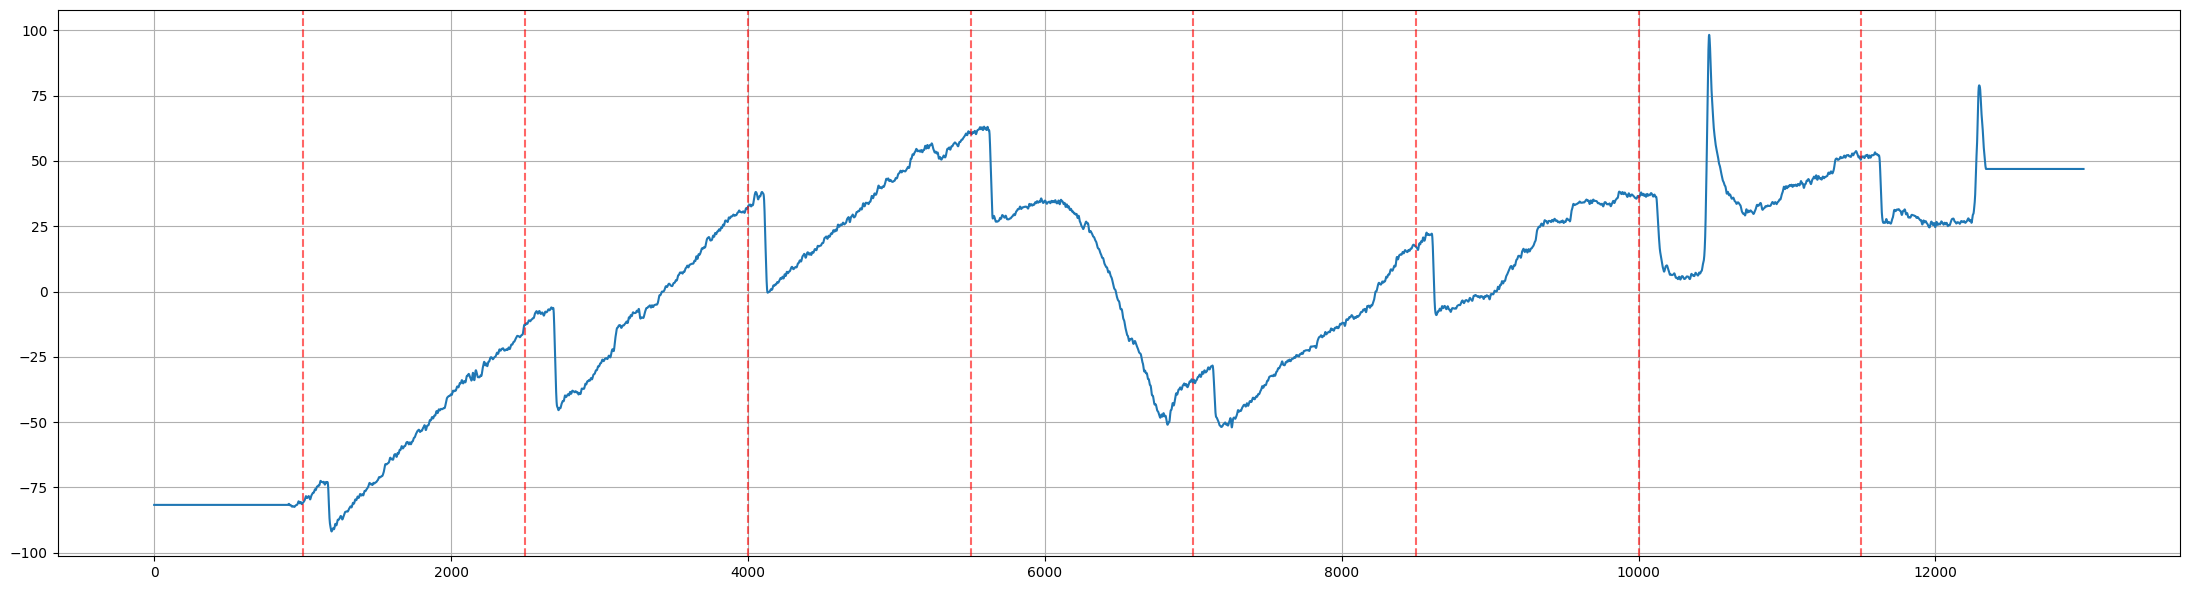

In [32]:
impulses = [1000, 2500, 4000, 5500, 7000, 8500, 10000, 11500]

s = df_et[3]["EOG_left_v"].to_numpy()

plt.figure(figsize=(22, 6))
plt.plot(s)

for x in impulses:
    plt.axvline(x, linestyle="--", alpha=0.6, color="red")

plt.grid()
plt.tight_layout()

# Статистика амплитуд

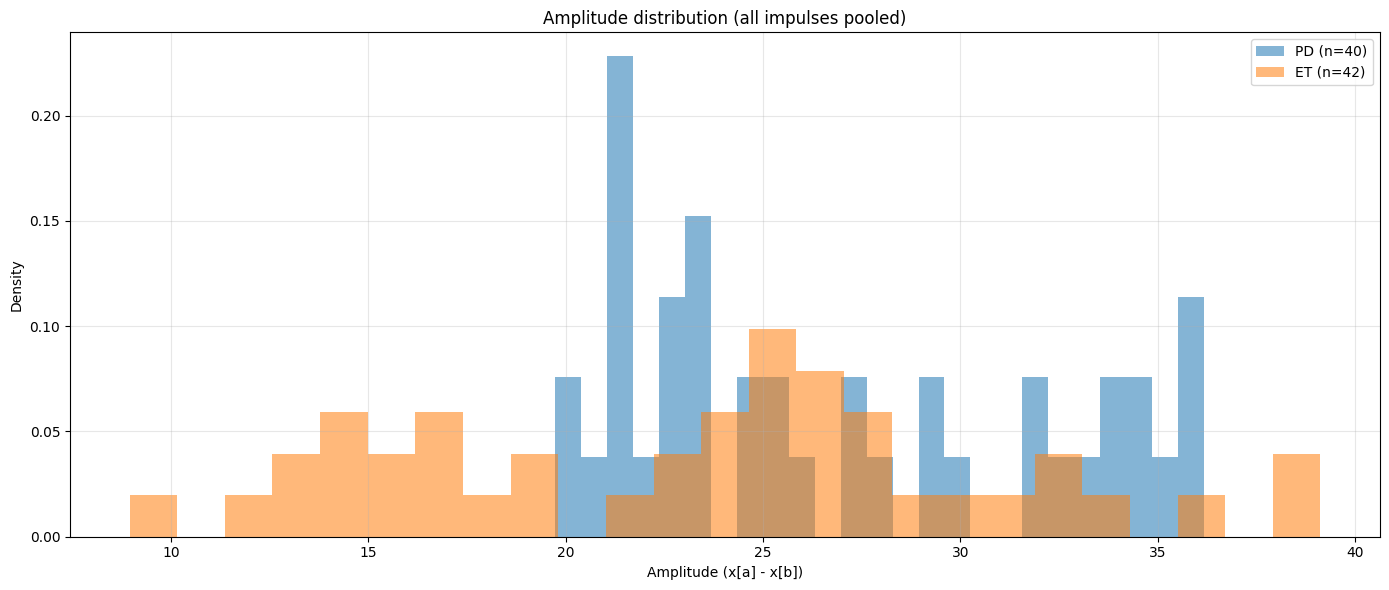

In [33]:
et_vals = amp_et.filter(like="patient_").to_numpy().ravel()
pd_vals = amp_pd.filter(like="patient_").to_numpy().ravel()

et_vals = et_vals[np.isfinite(et_vals)]
pd_vals = pd_vals[np.isfinite(pd_vals)]

bins = 25

plt.figure(figsize=(14, 6))
plt.hist(pd_vals, bins=bins, alpha=0.55, density=True, label=f"PD (n={len(pd_vals)})")
plt.hist(et_vals, bins=bins, alpha=0.55, density=True, label=f"ET (n={len(et_vals)})")
plt.title("Amplitude distribution (all impulses pooled)")
plt.xlabel("Amplitude (x[a] - x[b])")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


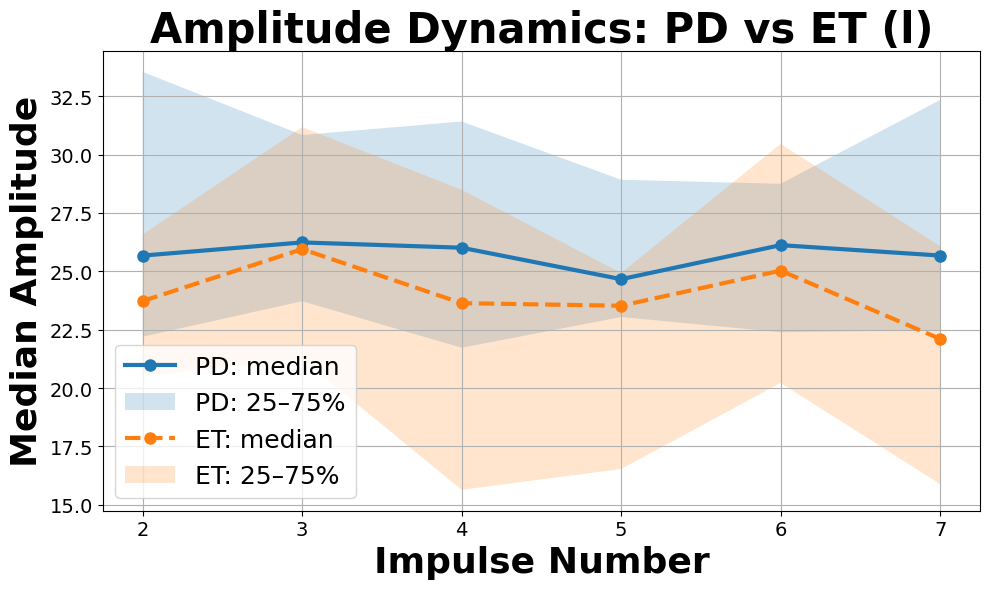

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def row_median_quantiles(df: pd.DataFrame, q_low=0.25, q_high=0.75):
    df = df.copy()
    patient_cols = [c for c in df.columns if c.startswith("patient_")]
    vals = df[patient_cols]

    med = vals.median(axis=1, skipna=True)
    q_lo = vals.apply(lambda row: np.nanquantile(row, q_low), axis=1)
    q_hi = vals.apply(lambda row: np.nanquantile(row, q_high), axis=1)

    if "Unnamed: 0" in df.columns:
        idx = df["Unnamed: 0"].values
        med.index = idx
        q_lo.index = idx
        q_hi.index = idx

    return med, q_lo, q_hi


med_pd, q25_pd, q75_pd = row_median_quantiles(amp_pd)
med_et, q25_et, q75_et = row_median_quantiles(amp_et)

fig, ax = plt.subplots(figsize=(10, 6))

x = med_pd.index.astype(int).values  # тут уже 2..7

ax.plot(
    x, med_pd.values,
    marker='o',
    linewidth=3,
    markersize=8,
    label='PD: median'
)
ax.fill_between(
    x,
    q25_pd.values,
    q75_pd.values,
    alpha=0.2,
    label='PD: 25–75%'
)

ax.plot(
    x, med_et.values,
    marker='o',
    linewidth=3,
    markersize=8,
    linestyle='--',
    label='ET: median'
)
ax.fill_between(
    x,
    q25_et.values,
    q75_et.values,
    alpha=0.2,
    label='ET: 25–75%'
)

ax.set_xlabel('Impulse Number', fontsize=26, fontweight='bold')
ax.set_ylabel('Median Amplitude', fontsize=26, fontweight='bold')
ax.set_title(f'Amplitude Dynamics: PD vs ET ({SIDE})', fontsize=30, fontweight='bold')

ax.tick_params(axis='both', labelsize=14)
ax.grid(True)
ax.legend(fontsize=18)

out_name_svg = f"PDvsET_amp_median_{SIDE}.svg"
fig.savefig(out_name_svg, format='svg', bbox_inches='tight')

plt.tight_layout()
plt.show()


# Статесты

In [35]:
import numpy as np
import pandas as pd
from scipy import stats

rows = []

patient_cols_pd = [c for c in amp_pd.columns if c.startswith("patient_")]
patient_cols_et = [c for c in amp_et.columns if c.startswith("patient_")]

x = amp_pd[patient_cols_pd].to_numpy(dtype=float).ravel()
y = amp_et[patient_cols_et].to_numpy(dtype=float).ravel()

x = x[np.isfinite(x)]
y = y[np.isfinite(y)]

def normality_p(arr: np.ndarray) -> float:
    arr = np.asarray(arr, dtype=float)
    arr = arr[np.isfinite(arr)]
    if len(arr) < 3:
        return np.nan
    if len(arr) <= 5000:
        return float(stats.shapiro(arr).pvalue)
    return float(stats.normaltest(arr).pvalue)

if len(x) < 3 or len(y) < 3:
    rows.append({
        "segment": "ALL",
        "n_PD": len(x), "n_ET": len(y),
        "p_bm": np.nan, "p_mwu": np.nan,
        "median_PD": np.nan, "median_ET": np.nan, "median_diff(PD-ET)": np.nan
    })
else:
    p_norm_x = normality_p(x)
    p_norm_y = normality_p(y)

    try:
        p_bm = float(stats.brunnermunzel(x, y, alternative="two-sided").pvalue)
    except Exception:
        p_bm = np.nan

    try:
        p_mwu = float(stats.mannwhitneyu(x, y, alternative="two-sided", method="auto").pvalue)
    except Exception:
        p_mwu = np.nan

    rows.append({
        "p_bm": p_bm, "p_mwu": p_mwu,
        "median_PD": float(np.median(x)),
        "median_ET": float(np.median(y)),
    })

stats_df = pd.DataFrame(rows)
display(stats_df)


,p_bm,p_mwu,median_PD,median_ET
0,0.050223,0.051958,25.335282,24.558079


In [36]:
from scipy import stats
import numpy as np

patient_cols_pd = [c for c in amp_pd.columns if str(c).startswith("patient_")]
patient_cols_et = [c for c in amp_et.columns if str(c).startswith("patient_")]

for i, imp in enumerate(amp_pd["Unnamed: 0"].astype(int).tolist()):
    x = amp_pd.loc[i, patient_cols_pd].to_numpy(float)
    y = amp_et.loc[i, patient_cols_et].to_numpy(float)

    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]

    px = stats.shapiro(x).pvalue if len(x) >= 3 else np.nan
    py = stats.shapiro(y).pvalue if len(y) >= 3 else np.nan

    if len(x) >= 3 and len(y) >= 3:
        try:
            p_bm = stats.brunnermunzel(x, y, alternative="two-sided").pvalue
        except Exception:
            p_bm = np.nan
        try:
            p_mwu = stats.mannwhitneyu(x, y, alternative="two-sided", method="auto").pvalue
        except Exception:
            p_mwu = np.nan
    else:
        p_bm = np.nan
        p_mwu = np.nan

    print(
        f"Impulse {imp}: "
        f"BM p={p_bm:.4g}, MWU p={p_mwu:.4g}, "
        f"nPD={len(x)}, nET={len(y)}"
    )



Impulse 2: BM p=0.4282, MWU p=0.4418, nPD=8, nET=8
Impulse 3: BM p=0.7921, MWU p=0.8357, nPD=6, nET=7
Impulse 4: BM p=0.4254, MWU p=0.4452, nPD=6, nET=7
Impulse 5: BM p=0.292, MWU p=0.3176, nPD=7, nET=7
Impulse 6: BM p=0.8969, MWU p=0.9452, nPD=6, nET=7
Impulse 7: BM p=0.211, MWU p=0.2343, nPD=7, nET=6


In [45]:
patient_cols_pd = [c for c in amp_pd.columns if str(c).startswith("patient_")]
patient_cols_et = [c for c in amp_et.columns if str(c).startswith("patient_")]

def patient_agg(df: pd.DataFrame, how: str) -> np.ndarray:
    vals = df[patient_cols_pd] if df is amp_pd else df[patient_cols_et]
    if how == "median":
        out = vals.median(axis=0, skipna=True).to_numpy(dtype=float)
    elif how == "mean":
        out = vals.mean(axis=0, skipna=True).to_numpy(dtype=float)
    else:
        raise ValueError("how must be 'median' or 'mean'")
    return out[np.isfinite(out)]

def run_patient_level(how: str) -> pd.DataFrame:
    x = patient_agg(amp_pd, how)
    y = patient_agg(amp_et, how)

    row = {
        "mode": how,
        "n_PD": len(x),
        "n_ET": len(y),
        "median_PD": float(np.median(x)) if len(x) else np.nan,
        "median_ET": float(np.median(y)) if len(y) else np.nan,
    }

    try:
        row["p_bm"] = float(stats.brunnermunzel(x, y, alternative="two-sided").pvalue)
    except Exception:
        row["p_bm"] = np.nan

    try:
        row["p_mwu"] = float(stats.mannwhitneyu(x, y, alternative="two-sided", method="auto").pvalue)
    except Exception:
        row["p_mwu"] = np.nan

    return pd.DataFrame([row])

stats_patient_median = run_patient_level("median")
stats_patient_mean   = run_patient_level("mean")

stats_patient = pd.concat([stats_patient_median, stats_patient_mean], ignore_index=True)
display(stats_patient)


,mode,n_PD,n_ET,median_PD,median_ET,p_bm,p_mwu
0,median,8,8,25.007736,25.770659,0.634056,0.645377
1,mean,8,8,25.507886,26.460089,0.709079,0.720901


# Проверка возраста

In [39]:
import numpy as np
from scipy import stats

pd_ages = np.array([44, 60, 47, 82, 66, 50, 79, 58, 54, 39], dtype=float)
et_ages = np.array([33, 74, 80, 41, 68, 53, 51, 19], dtype=float)

res = stats.mannwhitneyu(pd_ages, et_ages, alternative="two-sided", method="exact")
print(res)


MannwhitneyuResult(statistic=np.float64(46.0), pvalue=np.float64(0.6334384569678687))


# Сохранение файлов

In [40]:
import re, zipfile
import numpy as np
import pandas as pd
from google.colab import files

def _patient_cols(df):
    return [c for c in df.columns if str(c).startswith("patient_")]

def _patient_ids(cols):
    out = []
    for c in cols:
        m = re.search(r"\d+", str(c))
        out.append(int(m.group()) if m else None)
    return out

def patient_level_table(amp_df: pd.DataFrame, how: str) -> pd.DataFrame:
    cols = _patient_cols(amp_df)
    vals = amp_df[cols].apply(pd.to_numeric, errors="coerce")

    if how == "median":
        agg = vals.median(axis=0, skipna=True)
    elif how == "mean":
        agg = vals.mean(axis=0, skipna=True)
    else:
        raise ValueError("how must be 'median' or 'mean'")

    out = pd.DataFrame({
        "patient_id": _patient_ids(agg.index),
        "amp": agg.values.astype(float)
    }).dropna(subset=["patient_id"]).sort_values("patient_id").reset_index(drop=True)

    out["patient_id"] = out["patient_id"].astype(int)
    return out



In [41]:
import os, re
import numpy as np
import pandas as pd

SIDE = "l"  # "l" или "r"

impulses = [1000, 2500, 4000, 5500, 7000, 8500, 10000, 11500]

PD_REMAP = {0:0,1:1,2:2,3:3,4:None,5:4,6:5,7:None,8:None,9:None,10:None,11:6,12:7,13:8,14:None,15:None,16:9}
ET_REMAP = {0:0,1:1,2:None,3:2,4:None,5:3,6:4,7:5,8:6,9:7}

manual_base = "/content"
manual_ET = pd.read_csv(os.path.join(manual_base, f"{SIDE}_manual_ET.csv"))
manual_PD = pd.read_csv(os.path.join(manual_base, f"{SIDE}_manual_PD.csv"))

###
###
###
ROW_IDX = [0,1,2,3,4,5,6,7]

def extract_old_patient_ids(manual_df: pd.DataFrame, group: str):
    ids = set()
    pat = re.compile(rf"^{group}_(\d+)_(a|b)$")
    for c in manual_df.columns:
        m = pat.match(c)
        if m:
            ids.add(int(m.group(1)))
    return sorted(ids)

def build_latency_table_from_manual(manual_df: pd.DataFrame,
                                    group: str,
                                    remap: dict,
                                    dfs_group: list,
                                    row_idx: list[int],
                                    impulses: list[int]) -> pd.DataFrame:
    use_rows = [r for r in row_idx if 0 <= r < len(manual_df)]
    old_ids = extract_old_patient_ids(manual_df, group)

    new_ids = []
    old_to_new = {}
    for old in old_ids:
        new = remap.get(old, None)
        old_to_new[old] = new
        if new is not None and 0 <= new < len(dfs_group):
            new_ids.append(new)
    new_ids = sorted(set(new_ids))

    out = pd.DataFrame({
        "stim_no": [r + 1 for r in use_rows],
        "impulse": [impulses[r] for r in use_rows],
    })
    for new in new_ids:
        out[f"patient_{new}"] = np.nan

    for old in old_ids:
        new = old_to_new[old]
        if new is None or not (0 <= new < len(dfs_group)):
            continue

        col_a = f"{group}_{old}_a"
        if col_a not in manual_df.columns:
            continue

        for rr_i, r in enumerate(use_rows):
            a = manual_df.iloc[r][col_a]
            if pd.isna(a):
                continue
            a = int(a)
            out.loc[rr_i, f"patient_{new}"] = float(a - impulses[r])

    return out

lat_et = build_latency_table_from_manual(manual_ET, "ET", ET_REMAP, df_et, ROW_IDX, impulses)
lat_pd = build_latency_table_from_manual(manual_PD, "PD", PD_REMAP, df_pd, ROW_IDX, impulses)

lat_et.to_csv(f"{SIDE}_latency_ET.csv", index=False)
lat_pd.to_csv(f"{SIDE}_latency_PD.csv", index=False)

print("ET latency table:")
display(lat_et)
print("PD latency table:")
display(lat_pd)


ET latency table:


,stim_no,impulse,patient_0,patient_1,patient_2,patient_3,patient_4,patient_5,patient_6,patient_7
0,1,1000,115.0,126.0,180.0,167.0,NaN,NaN,NaN,150.0
1,2,2500,125.0,91.0,315.0,188.0,212.0,131.0,153.0,94.0
2,3,4000,113.0,105.0,166.0,95.0,123.0,130.0,NaN,90.0
3,4,5500,147.0,162.0,190.0,115.0,131.0,96.0,119.0,NaN
4,5,7000,103.0,95.0,177.0,130.0,86.0,109.0,NaN,76.0
5,6,8500,109.0,18.0,174.0,107.0,125.0,NaN,78.0,80.0
6,7,10000,126.0,NaN,179.0,108.0,132.0,121.0,NaN,81.0
7,8,11500,72.0,NaN,181.0,108.0,NaN,87.0,115.0,NaN


PD latency table:


,stim_no,impulse,patient_0,patient_1,patient_2,patient_3,patient_4,patient_5,patient_6,patient_7,patient_8,patient_9
0,1,1000,128.0,172.0,173.0,NaN,182.0,NaN,NaN,NaN,176.0,137.0
1,2,2500,153.0,192.0,169.0,NaN,126.0,NaN,224.0,134.0,151.0,117.0
2,3,4000,140.0,158.0,138.0,NaN,155.0,NaN,114.0,NaN,97.0,NaN
3,4,5500,147.0,141.0,128.0,NaN,NaN,NaN,46.0,NaN,91.0,120.0
4,5,7000,NaN,132.0,155.0,NaN,152.0,NaN,105.0,118.0,115.0,135.0
5,6,8500,NaN,127.0,124.0,NaN,107.0,NaN,56.0,NaN,43.0,82.0
6,7,10000,122.0,126.0,133.0,NaN,152.0,NaN,92.0,83.0,159.0,NaN
7,8,11500,140.0,129.0,110.0,NaN,166.0,NaN,NaN,NaN,68.0,NaN


In [42]:
import numpy as np
import pandas as pd

def _patient_cols(df):
    return [c for c in df.columns if str(c).startswith("patient_")]

def add_row_stats(df, value_cols, prefix):
    df = df.copy()
    df[f"{prefix}_mean"] = df[value_cols].mean(axis=1, skipna=True)
    df[f"{prefix}_median"] = df[value_cols].median(axis=1, skipna=True)
    return df

def to_stim_no(df):
    df = df.copy()
    if "stim_no" in df.columns:
        return df
    if "Unnamed: 0" in df.columns:
        return df.rename(columns={"Unnamed: 0": "stim_no"})
    raise KeyError("!!!")

lat_et_mid = lat_et.iloc[1:-1].reset_index(drop=True)
lat_pd_mid = lat_pd.iloc[1:-1].reset_index(drop=True)

lat_et_mid = add_row_stats(lat_et_mid, _patient_cols(lat_et_mid), "lat")
lat_pd_mid = add_row_stats(lat_pd_mid, _patient_cols(lat_pd_mid), "lat")


amp_et_k = to_stim_no(amp_et)
amp_pd_k = to_stim_no(amp_pd)

amp_et_sum = add_row_stats(amp_et_k, _patient_cols(amp_et_k), "amp")[["stim_no", "amp_mean", "amp_median"]]
amp_pd_sum = add_row_stats(amp_pd_k, _patient_cols(amp_pd_k), "amp")[["stim_no", "amp_mean", "amp_median"]]

lat_et_mid = lat_et_mid.merge(amp_et_sum, on="stim_no", how="left")
lat_pd_mid = lat_pd_mid.merge(amp_pd_sum, on="stim_no", how="left")

print("ET (latency + amp):")
display(lat_et_mid)

print("PD/BP (latency + amp):")
display(lat_pd_mid)


ET (latency + amp):


,stim_no,impulse,patient_0,patient_1,patient_2,patient_3,patient_4,patient_5,patient_6,patient_7,lat_mean,lat_median,amp_mean,amp_median
0,2,2500,125.0,91.0,315.0,188.0,212.0,131.0,153.0,94.0,163.625000,142.0,24.281767,23.725793
1,3,4000,113.0,105.0,166.0,95.0,123.0,130.0,NaN,90.0,117.428571,113.0,26.115121,25.951229
2,4,5500,147.0,162.0,190.0,115.0,131.0,96.0,119.0,NaN,137.142857,131.0,22.899523,23.635182
3,5,7000,103.0,95.0,177.0,130.0,86.0,109.0,NaN,76.0,110.857143,103.0,21.143605,23.525516
4,6,8500,109.0,18.0,174.0,107.0,125.0,NaN,78.0,80.0,98.714286,107.0,23.904889,25.029525
5,7,10000,126.0,NaN,179.0,108.0,132.0,121.0,NaN,81.0,124.500000,123.5,21.871146,22.105445


PD/BP (latency + amp):


,stim_no,impulse,patient_0,patient_1,patient_2,patient_3,patient_4,patient_5,patient_6,patient_7,patient_8,patient_9,lat_mean,lat_median,amp_mean,amp_median
0,2,2500,153.0,192.0,169.0,NaN,126.0,NaN,224.0,134.0,151.0,117.0,158.250000,152.0,27.286044,25.673387
1,3,4000,140.0,158.0,138.0,NaN,155.0,NaN,114.0,NaN,97.0,NaN,133.666667,139.0,26.984038,26.238080
2,4,5500,147.0,141.0,128.0,NaN,NaN,NaN,46.0,NaN,91.0,120.0,112.166667,124.0,26.899049,26.011295
3,5,7000,NaN,132.0,155.0,NaN,152.0,NaN,105.0,118.0,115.0,135.0,130.285714,132.0,26.427697,24.663633
4,6,8500,NaN,127.0,124.0,NaN,107.0,NaN,56.0,NaN,43.0,82.0,89.833333,94.5,26.519429,26.121639
5,7,10000,122.0,126.0,133.0,NaN,152.0,NaN,92.0,83.0,159.0,NaN,123.857143,126.0,27.521560,25.675794


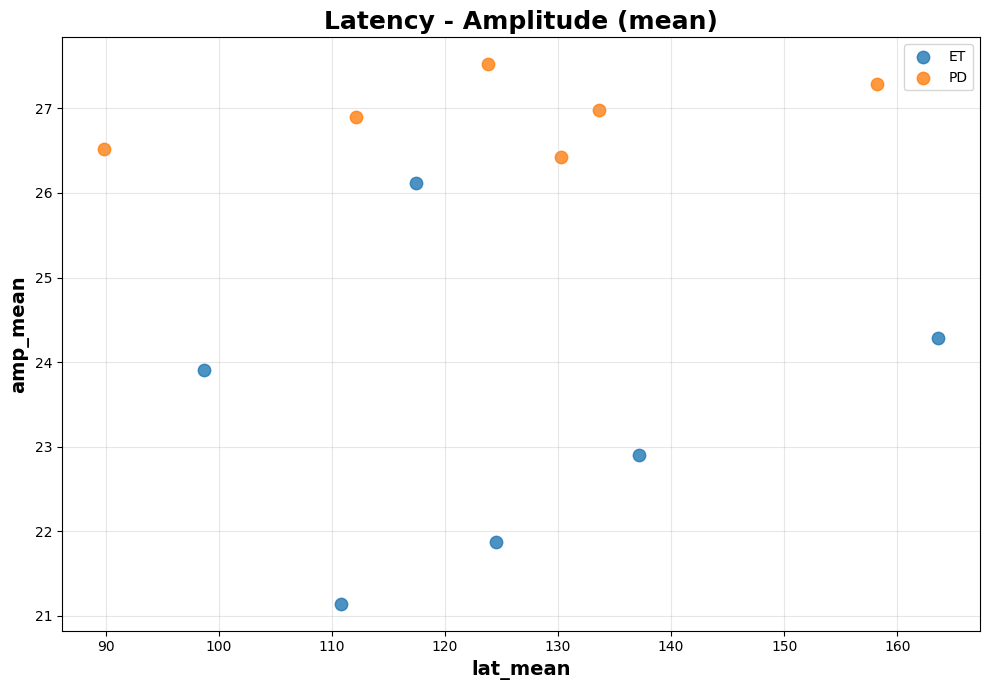

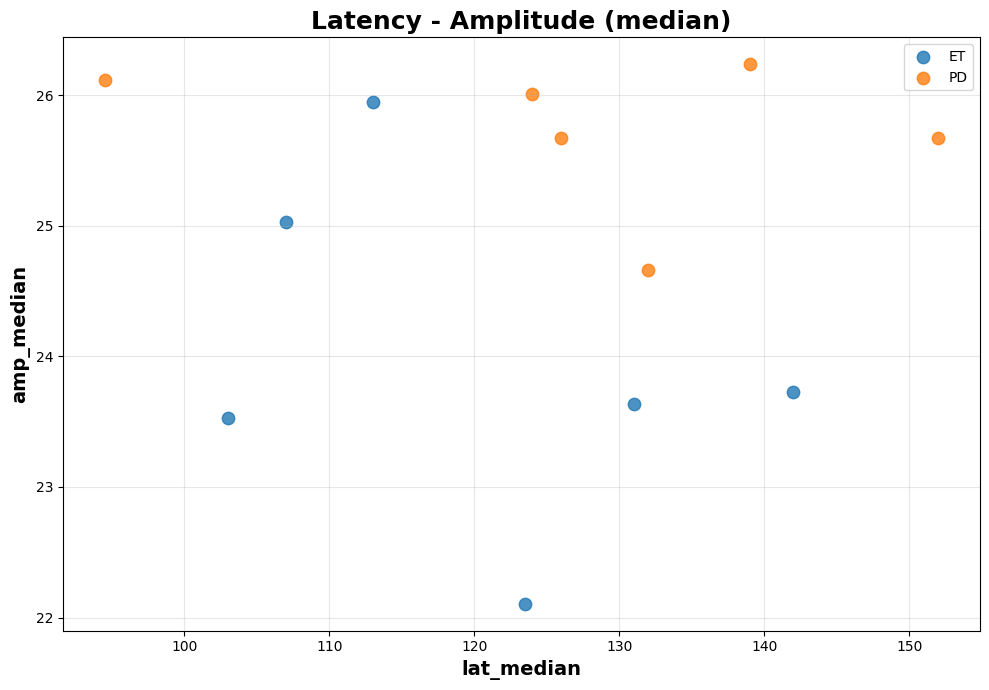

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def _scatter_two_groups(df_et, df_pd, xcol, ycol, title, xlabel, ylabel):
    x1 = df_et[xcol].to_numpy(dtype=float)
    y1 = df_et[ycol].to_numpy(dtype=float)
    m1 = np.isfinite(x1) & np.isfinite(y1)

    x2 = df_pd[xcol].to_numpy(dtype=float)
    y2 = df_pd[ycol].to_numpy(dtype=float)
    m2 = np.isfinite(x2) & np.isfinite(y2)

    plt.figure(figsize=(10, 7))
    plt.scatter(x1[m1], y1[m1], s=80, alpha=0.8, label="ET")
    plt.scatter(x2[m2], y2[m2], s=80, alpha=0.8, label="PD")
    plt.title(title, fontsize=18, fontweight="bold")
    plt.xlabel(xlabel, fontsize=14, fontweight="bold")
    plt.ylabel(ylabel, fontsize=14, fontweight="bold")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

_scatter_two_groups(
    lat_et_mid, lat_pd_mid,
    xcol="lat_mean", ycol="amp_mean",
    title="Latency - Amplitude (mean)",
    xlabel="lat_mean", ylabel="amp_mean"
)

_scatter_two_groups(
    lat_et_mid, lat_pd_mid,
    xcol="lat_median", ycol="amp_median",
    title="Latency - Amplitude (median)",
    xlabel="lat_median", ylabel="amp_median"
)
